# New implementation of simulation for iterative estimation of Beta-distribution parameters that fit the distribution of stationary activity

In [62]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm

In [2]:
def coupling_weights(N, K, lambda_, seed):
    w = scipy.sparse.random(N, N, density=K/N, random_state=seed, format='csr')
    # normalize each row such that sum_j w_ij = lambda
    w = w.multiply(lambda_/w.sum(axis=1))
    w = w.tocsr()
    return w

In [3]:
def external_spiking_probability(N, mu, h_, seed, dt=1):
    np.random.seed(seed)
    # make empty sparse vector of size N
    h = scipy.sparse.csr_matrix((1,N))
    # add mu*N random entries with value h_
    h[0,np.random.choice(N, int(mu*N), replace=False)] = 1 - np.exp(-h_*dt)
    return h

In [4]:
def transfer(x):
    x[x<0] = 0
    x[x>1] = 1
    return x

In [5]:
def step(x, w, p_h, rng):
    # spike with probability w * x
    p_rec = transfer(w @ x)
    x = np.zeros(N)
    # continue only for non-zero entries to save computation
    id_nonzero = np.nonzero(p_rec)[0]
    if np.size(id_nonzero) > 0:
        id_spike = rng.random(np.size(id_nonzero)) < p_rec[id_nonzero]
        x[id_nonzero[id_spike]] = 1
    # or spike with probability h
    id_nonzero = np.nonzero(p_h)[1]
    if np.size(id_nonzero) > 0:
        id_spike = np.array(rng.random(np.size(id_nonzero)) < p_h[0,id_nonzero])[0,:]
        # add spikes to x (if already spiked this will remain 1)
        x[id_nonzero[id_spike]] = 1
    return x

### Verify agains analytic calculation of mean activity

In [115]:
N=int(1e4)
K=100
list_h=np.logspace(-5,1,6)
mu=0.2
dt=1
# prepare for reset in loop
p_h = external_spiking_probability(N, mu, 0, seed=1234, dt=1)
# recurrent coupling fixed
lambda_ = 0.9
w = coupling_weights(N, K, lambda_, seed=1234)

# run simulations
T = 10000
T_burn = 1000
list_a = np.zeros_like(list_h)
rng = np.random.default_rng(1234)
for (i,h) in tqdm(enumerate(list_h)):
    p_h = external_spiking_probability(N, mu, h, seed=1234, dt=1)
    activity = np.zeros(T)
    x = np.zeros(N)
    for t in range(T):
        x = step(x, w, p_h, rng)
        activity[t] = np.mean(x)
    list_a[i] = np.mean(activity[T_burn:])

/Users/johannes/miniforge3/envs/finite-observation/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
6it [01:21, 13.60s/it]


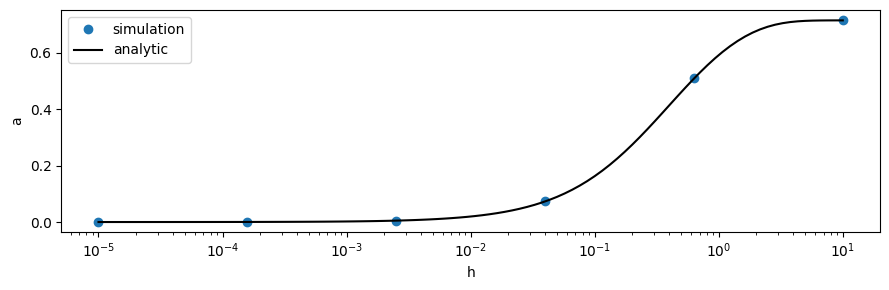

In [116]:
def a(h, mu, lambda_, dt=1):
    return mu*(1-np.exp(-h*dt))/(1-lambda_*(1-mu)-lambda_*mu*np.exp(-h*dt))

list_h_ana = np.logspace(-5,1,100)
list_a_ana = [a(h, mu, lambda_) for h in list_h_ana]

plt.figure(figsize=(9,3))
plt.plot(list_h_ana, list_a_ana, '-', label='analytic', color='black')
plt.plot(list_h, list_a, 'o', label='simulation')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('a')
plt.legend()
plt.tight_layout()

### Fitting beta distribution


In [110]:
def fit_beta_distribution(data, delta, seed=1234):
    np.random.seed(seed)
    # add very small jitter to avoid problems with delta distributions
    data = data + np.random.randn(len(data))*delta/3
    # IMPORTANT: The beta distribution is defined on the interval [0,1] but because of the discretization we need to shift the support by delta and scale it by 1+2*delta
    a,b,loc,scale = stats.beta.fit(data, floc=-delta, fscale=1+2*delta) 
    return a,b,loc,scale

In [88]:
N=int(1e4)
K=100
mu=0.2
lambda_ = 0.0
h_ = 10
seed = 1000
p_h = external_spiking_probability(N, mu, h_, seed)
print(type(p_h))
w = coupling_weights(N, K, lambda_, seed)
print(type(w))

T = 10000
activity = np.zeros(T, dtype=np.float64)
rng = np.random.RandomState(seed)
x = np.zeros(N)
for t in range(T):
    x = step(x, w, p_h, rng)
    activity[t] = np.sum(x)

/Users/johannes/miniforge3/envs/finite-observation/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


[0.000e+00 1.000e-04 2.000e-04 ... 9.998e-01 9.999e-01 1.000e+00]
0.0001 0.0001
1.0
1.52e+07,6.09e+07,-0.0001,1.0002


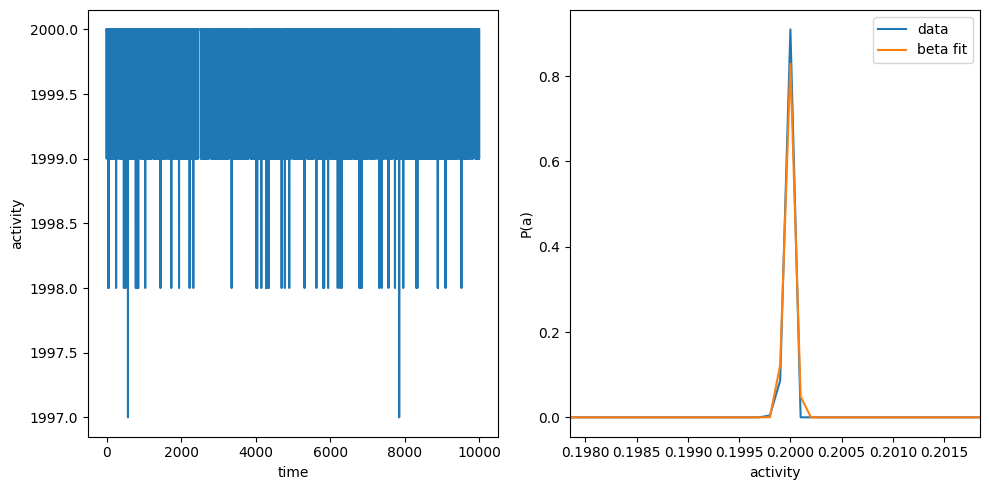

In [111]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(activity, label='data')
axes[0].set_xlabel('time') 
axes[0].set_ylabel('activity')

delta = 1/N
support = np.linspace(0,1,N+1)
print(support)
print(delta, support[1]-support[0])
data = activity[1000:]/N
# histogram needs bin edges but we work with bin centers, hence need to shift support
pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
print(np.sum(pmf_data))
axes[1].plot(support, pmf_data, label='data')
a,b,loc,scale = fit_beta_distribution(data, delta, seed)
print(f'{a:.2e},{b:.2e},{loc},{scale}')
pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
pmf_beta = pmf_beta/np.sum(pmf_beta)
axes[1].plot(support, pmf_beta, label='beta fit')
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
axes[1].legend()
range_data = support[np.nonzero(pmf_data)]
if len(range_data) > 20:
    axes[1].set_xlim([range_data[0],range_data[-1]])
else:
    axes[1].set_xlim([np.median(range_data)-20*delta,np.median(range_data)+20*delta])
plt.tight_layout()